# Structure

- 1. Data preparation
    - 1.1. Import
    - 1.2. Filter
    - 1.3. Enrich
    - 1.4. Random test and train split
    - 1.5. k-fold cross-validation
- 2. Data prediction
    - 2.1 Import Libraries and Data
    - 2.2 Regression models and hyperparameter grids
    - 2.3 Cross-validation with GridSearchCV
    - 2.4 Model performance evaluation
    - 2.5 Select best model
    - 2.6 Predict future values
- 3. Data prescription
    - 3.1 Baseline Scheduling
    - 3.2 Smart Stochastic scheduling (SSS)
        - 3.2.1 Loss function
        - 3.2.2 Stochastic model
- 4. Sensitivity analysis
- 5. GUI

# 1. Data preparation

## 1.1. Import

Load the needed data:

- job_logs.csv = Logs of historical Jobs with Timestamps
- weekly_releases.csv = List of Jobs that are executed every week

In [1]:
import pandas as pd

# Load historical data into a Pandas DataFrame
logs = pd.read_csv('demo_data/data/job_logs.csv')

# Load scheduled job data into a Pandas DataFrame
releases = pd.read_csv('demo_data/data/weekly_releases.csv')


## 1.2 Filter

Filter everything out that is not needed

In [2]:
# Keep only the rows in logs whose names appear in releases.
logs = logs[logs['ProcessName'].isin(releases['Name'])]

Remove outliners

In [3]:
# Calculate the interquartile range (IQR)
Q1 = logs['DateDiff'].quantile(0.25)
Q3 = logs['DateDiff'].quantile(0.75)
IQR = Q3 - Q1

# Remove outliners
filtered_logs = logs[~((logs['DateDiff'] < (Q1 - 1.5 * IQR)) | (logs['DateDiff'] > (Q3 + 1.5 * IQR)))]

## 1.3 Enrich

Adding min, max, mean and median execution time as well as the weekday and calenderweek to the data

In [4]:
# Format columns as datetime
filtered_logs.loc[:, 'date'] = pd.to_datetime(filtered_logs['StartTime']).dt.date.copy()
filtered_logs.loc[:, 'time'] = pd.to_datetime(filtered_logs['StartTime']).dt.time.copy()

# Add weekday
filtered_logs.loc[:, 'weekday'] = pd.to_datetime(filtered_logs['StartTime']).dt.dayofweek.copy()

# Add calendar week
filtered_logs.loc[:, 'calendarweek'] = pd.to_datetime(filtered_logs['StartTime']).dt.isocalendar().week.astype('int').copy()

# Rename the 'DateDiff' column to 'ExecTime'
filtered_logs = filtered_logs.rename(columns={'DateDiff': 'ExecTime'})

# Sort DataFrame by process name and date
filtered_logs = filtered_logs.sort_values(by=['ProcessName', 'date'])

# Add last_ExecTime
filtered_logs.loc[:, 'last_ExecTime'] = filtered_logs.groupby('ProcessName')['ExecTime'].shift(1).copy()

# Add mean_ExecTime
filtered_logs.loc[:, 'mean_ExecTime'] = filtered_logs.groupby('ProcessName')['ExecTime'].transform('mean').copy()

# Add max_ExecTime
filtered_logs.loc[:, 'max_ExecTime'] = filtered_logs.groupby('ProcessName')['ExecTime'].transform('max').copy()

# Add min_ExecTime
filtered_logs.loc[:, 'min_ExecTime'] = filtered_logs.groupby('ProcessName')['ExecTime'].transform('min').copy()

# Add median_ExecTime
filtered_logs.loc[:, 'median_ExecTime'] = filtered_logs.groupby('ProcessName')['ExecTime'].transform('median').copy()

# Replace NaN with zero on all columns
filtered_logs = filtered_logs.fillna(0)

# filtered_logs.head()


In [5]:
# Save filtered_logs as csv
#filtered_logs.to_csv("demo_data/filtered_logs.csv", sep='\t')

In [6]:
from sklearn.preprocessing import LabelEncoder

# Preprocess the data
filtered_logs['StartTime'] = pd.to_datetime(filtered_logs['StartTime'])
filtered_logs['date'] = pd.to_datetime(filtered_logs['date'])
filtered_logs['weekday'] = filtered_logs['StartTime'].dt.weekday
filtered_logs['calenderweek'] = filtered_logs['StartTime'].dt.isocalendar().week
filtered_logs['calenderweek'] = pd.to_datetime(filtered_logs['StartTime']).dt.isocalendar().week.astype(int)

# Label encoding for categorical features
encoder = LabelEncoder()
filtered_logs['ProcessName'] = encoder.fit_transform(filtered_logs['ProcessName'])

# Define the features and target
X = filtered_logs[['ProcessName', 'weekday', 'calenderweek', 'last_ExecTime', 'mean_ExecTime', 'max_ExecTime']]
y = filtered_logs['ExecTime']

## 1.4 Random test and train split

The idea behind a test and train split is to evaluate the performance of a machine learning model on unseen data. The aim of machine learning is to learn patterns and relationships from a dataset that can be used to make predictions on new, unseen data. To ensure that the model can generalize well to new data, it is important to test its performance on a separate set of data that was not used for training.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 1.5 k-fold cross-validation

K-fold cross-validation is a model evaluation technique that helps assess a model's performance on unseen data. It is widely used to reduce the risk of overfitting, estimate the generalization error, and select the best model. The dataset is divided into k equally-sized folds (or partitions), where k is a positive integer (in our case five). The model is trained on k-1 folds and validated on the remaining fold. This process is repeated k times, ensuring that each fold is used as the validation set exactly once.

In scikit-learn's KFold class, the parameters n_splits, shuffle, and random_state have the following meanings:

1. **n_splits**: The number of folds (k) to divide the dataset into. This parameter should be set to a positive integer (typically between 5 and 10). Higher values of k result in a lower bias but higher variance in model evaluation, whereas lower values of k can lead to a higher bias but lower variance.
2. **shuffle**: This is a boolean parameter. When set to True, the dataset will be shuffled before splitting into folds. Shuffling is useful when the dataset has an inherent order that might affect the model's performance during cross-validation. When set to False, the dataset will not be shuffled before splitting, and the folds will be created by sequentially selecting data points.
3. **random_state**: This parameter is used to control the randomness when shuffling the dataset. If set to an integer, it serves as the seed for the random number generator, ensuring that the shuffling is consistent across multiple runs. This helps in achieving reproducible results. When set to None, the random number generator uses a different seed in each run, resulting in a different shuffling of the dataset.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [8]:
# Set up k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 2. Data prediction

## 2.1 Import Libraries and Data

- **Scikit-learn (sklearn)**: Scikit-learn is a popular machine learning library for Python. It provides a comprehensive collection of machine learning algorithms for classification, regression, clustering, dimensionality reduction, and other tasks. Scikit-learn also includes tools for preprocessing data, model selection, and evaluation, making it a complete package for building and deploying machine learning models. It is built on top of Numpy, Scipy, and Matplotlib, and it is designed to be easy to use and highly efficient. Source: https://scikit-learn.org/stable/install.html
- **XGBoost**: XGBoost (eXtreme Gradient Boosting) is an open-source, highly efficient, and flexible machine learning library designed for gradient boosting trees. It was developed by Tianqi Chen and Carlos Guestrin and has gained significant popularity in the machine learning community due to its performance and scalability. Source: https://xgboost.readthedocs.io/en/stable/python/python_intro.html

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import time

## 2.2 Regression models and hyperparameter grids

**Regression models:**
Regression is a supervised learning technique used for predicting continuous numerical values. It is a statistical method that models the relationship between a dependent variable (also known as the target or response variable) and one or more independent variables (also known as the predictors or explanatory variables). Source: https://scikit-learn.org/stable/supervised_learning.html

Here are brief descriptions of some popular regression models:

1. **Linear Regression**: Linear regression is a simple and widely used linear approach to modeling the relationship between a dependent variable and one or more independent variables. It assumes a linear relationship between the variables and tries to fit a straight line through the data that minimizes the sum of the squared errors.

2. **Ridge Regression**: Ridge regression is a regularized version of linear regression that adds a penalty term to the cost function to prevent overfitting. It uses L2 regularization to shrink the coefficients towards zero, which reduces the variance of the estimates and improves the model's generalization performance.

3. **Lasso Regression**: Lasso regression is another regularized version of linear regression that uses L1 regularization to shrink the coefficients towards zero. It can be used for feature selection, as it tends to drive some coefficients to exactly zero, which removes the corresponding predictors from the model.

4. **Elastic Regression**: Elastic regression is a combination of ridge and lasso regression that uses a mixture of L1 and L2 regularization to balance the benefits of both. It can be tuned to favor either L1 or L2 regularization, or a mixture of both.

5. **Decision Tree Regression**: Decision tree regression is a non-parametric method that recursively splits the data into subsets based on the values of the predictors, and fits a simple model (such as a constant value) in each subset. It is easy to interpret and can capture non-linear relationships between the variables, but can suffer from overfitting.

6. **Random Forest Regression**: Random forest regression is an ensemble method that combines multiple decision tree regressors to improve the prediction accuracy and reduce overfitting. It randomly selects subsets of the data and variables to build each tree, and aggregates the predictions of the trees to produce the final output.

7. **Gradient Boosting Regression**: Gradient boosting regression is another ensemble method that combines multiple weak models (such as decision trees) to produce a strong predictive model. It trains each model sequentially to correct the errors of the previous model, and uses gradient descent to minimize the loss function.

8. **XGBoost**: XGBoost is an optimized implementation of gradient boosting that uses a variety of techniques (such as regularization, early stopping, and parallel processing) to improve the performance and scalability of the algorithm. It is often used in machine learning competitions and has been shown to achieve state-of-the-art results on a wide range of datasets.

**Hyperparameter tuning:**
Hyperparameter tuning is the process of finding the best set of hyperparameters for a machine learning model to optimize its performance. Hyperparameters are configuration variables that govern the training process and cannot be learned directly from the data. They can have a significant impact on the model's performance, and thus, finding the right combination is crucial for building a successful model. In this case the hyperparameter tuning is done with GridSearchCV. Source: https://scikit-learn.org/stable/modules/grid_search.html

In [10]:
# every regressior model with its hyperparameter grids
models = [
    {'name': 'Linear', 'model': LinearRegression(), 'param_grid': {}}, # no hyperparamters
    {'name': 'Ridge', 'model': Ridge(), 'param_grid': {'alpha': [0.1, 1, 10]}},
    {'name': 'Lasso', 'model': Lasso(), 'param_grid': {'alpha': [0.1, 1, 10]}},
    {'name': 'Elastic Net', 'model': ElasticNet(), 'param_grid': {'alpha': [0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]}},
    {'name': 'Decision Tree', 'model': DecisionTreeRegressor(), 'param_grid': {'max_depth': [None, 5, 10]}},
    {'name': 'Random Forest', 'model': RandomForestRegressor(), 'param_grid': {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10]}},
    {'name': 'Gradient Boosting', 'model': GradientBoostingRegressor(), 'param_grid': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}},
    {
        'name': 'XGBoost',
        'model': xgb.XGBRegressor(objective='reg:squarederror'),
        'param_grid': {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }
    }
]

In [11]:
# create a dataframe to save results
results = {
    'Model': [],
    'Mean Squared Error': [],
    'R2 Score': [],
    'Learning Time': []
}

results_df = pd.DataFrame(results)

## 2.3 Cross-validation with GridSearchCV

We train and evaluate multiple models using cross-validation and grid search for hyperparameter tuning.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

In [12]:
models_dict = {}

for m in models:
    print(f"Training and evaluating {m['name']}...")
    grid_search = GridSearchCV(m['model'], m['param_grid'], scoring='neg_mean_squared_error', cv=kfold, verbose=0)
    start_time = time.time()
    grid_result = grid_search.fit(X_train, y_train)
    best_model = grid_result.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Measure the time it takes to train the model
    end_time = time.time()
    learning_time = end_time - start_time
    
    # Assign values
    key = f"{m['name']}"
    value = best_model
    models_dict[key] = value
    
    print(f"{m['name']}:")
    print(f"  Mean Squared Error: {mse:.2f}")
    print(f"  R2 Score: {r2:.2f}")
    print(f"  Learning Time: {learning_time:.2f}s")
    print()
    
    # Create a new DataFrame with the results for this model
    model_results = pd.DataFrame({'Model': key, 'Mean Squared Error': [mse], 'R2 Score': [r2], 'Learning Time': [learning_time]})
    
    # Concatenate the new DataFrame to the existing results DataFrame
    results_df = pd.concat([results_df, model_results], ignore_index=True)
    
print(results_df)

Training and evaluating Linear...
Linear:
  Mean Squared Error: 20301.35
  R2 Score: 0.96
  Learning Time: 0.19s

Training and evaluating Ridge...
Ridge:
  Mean Squared Error: 20301.37
  R2 Score: 0.96
  Learning Time: 0.23s

Training and evaluating Lasso...
Lasso:
  Mean Squared Error: 20303.79
  R2 Score: 0.96
  Learning Time: 1.51s

Training and evaluating Elastic Net...
Elastic Net:
  Mean Squared Error: 20846.49
  R2 Score: 0.96
  Learning Time: 3.06s

Training and evaluating Decision Tree...
Decision Tree:
  Mean Squared Error: 20644.84
  R2 Score: 0.96
  Learning Time: 3.87s

Training and evaluating Random Forest...
Random Forest:
  Mean Squared Error: 20486.35
  R2 Score: 0.96
  Learning Time: 369.88s

Training and evaluating Gradient Boosting...
Gradient Boosting:
  Mean Squared Error: 20391.87
  R2 Score: 0.96
  Learning Time: 1584.03s

Training and evaluating XGBoost...
XGBoost:
  Mean Squared Error: 20377.28
  R2 Score: 0.96
  Learning Time: 534.31s

               Model  M

## 2.4 Model performance evaluation
Visualize the results from the GridSearch.

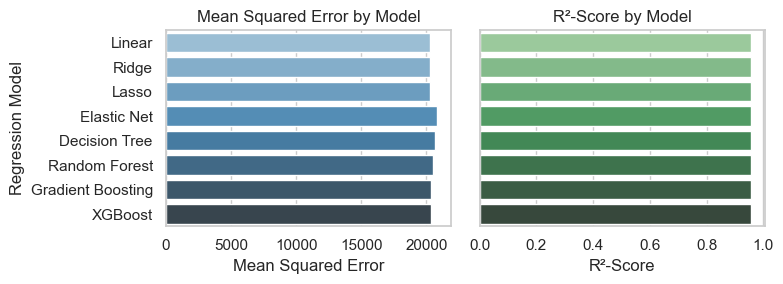

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style='whitegrid')

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# Plot Mean Squared Error
sns.barplot(x='Mean Squared Error', y='Model', data=results_df, ax=ax[0], palette='Blues_d')
ax[0].set_xlabel('Mean Squared Error')
ax[0].set_ylabel('Regression Model')
ax[0].set_title('Mean Squared Error by Model')

# Plot R2 Score
sns.barplot(x='R2 Score', y='Model', data=results_df, ax=ax[1], palette='Greens_d')
ax[1].set_xlabel('R²-Score')
#ax[1].set_ylabel('Model')
ax[1].set_title('R²-Score by Model')
ax[1].set_ylabel('')
ax[1].set_yticklabels([])
ax[1].set_xlim(left=0)

# Adjust layout
plt.tight_layout()

# Save the plot as an SVG file
plt.savefig("demo_data/images/models_evaluation.svg", format="svg")

# Display the plot
plt.show()

## 2.5 Select best model

In [14]:
# Create a new column with the product of "Mean Squared Error" and "R2 Score"
results_df['R2 x 1/MSE'] = results_df['R2 Score'] * 1 / results_df['Mean Squared Error']

# Find the index of the row with the highest product value
idx_max_mse_r2 = results_df['R2 x 1/MSE'].idxmax()

# Get the model name for the highest-scoring row
best_model_name = list({results_df.loc[idx_max_mse_r2, 'Model']})[0]

# Print the model name and the product value for the highest-scoring row
print(f"Model with highest R2 x 1/MSE: " + best_model_name)
print(f"Highest R2 x 1/MSE value: {results_df.loc[idx_max_mse_r2, 'R2 x 1/MSE']:.2f} * 1e8")

# Assign the best model
model = models_dict[best_model_name]

# Assign mse
model_mse = results_df.loc[idx_max_mse_r2, 'Mean Squared Error']
print(model, model_mse)

Model with highest R2 x 1/MSE: Linear
Highest R2 x 1/MSE value: 0.00 * 1e8
LinearRegression() 20301.352820851942


## 2.6 Predict future values

In [15]:
import datetime

# Load scheduled job data into a Pandas DataFrame
future_jobs = pd.read_csv('demo_data/data/weekly_releases.csv')

# Sort by Name
future_jobs = future_jobs.sort_values(by=['Name'], ascending=True)

# Label encoding for categorical features
encoder = LabelEncoder()
future_jobs['Name'] = encoder.fit_transform(future_jobs['Name'])

# add a new column with a constant value
future_jobs['StartTime'] = datetime.datetime.now()

# Group by name and select row with latest date_time
df1_latest = filtered_logs.groupby("ProcessName").apply(lambda x: x.loc[x["StartTime"].idxmax()]).reset_index(drop=True)

# Convert start column to datetime type
#df2["start"] = pd.to_datetime(df2["start"])

# Merge dataframes
future_jobs = pd.merge(future_jobs, df1_latest[["ProcessName", "last_ExecTime", "mean_ExecTime", "max_ExecTime", "min_ExecTime", "median_ExecTime"]], left_on="Name", right_on="ProcessName", how="left")

Create a new dataframe with the upcoming jobs.

In [16]:
# Preprocess the future job data
future_jobs['StartTime'] = pd.to_datetime(future_jobs['StartTime'])
future_jobs['weekday'] = future_jobs['StartTime'].dt.weekday
future_jobs['calenderweek'] = future_jobs['StartTime'].dt.isocalendar().week

# Define the features
X_future = future_jobs[['ProcessName', 'weekday', 'calenderweek', 'last_ExecTime', 'mean_ExecTime', 'max_ExecTime']]

# Standardize the data
X_future = scaler.transform(X_future)

# Make a prediction for the future job
future_ExecTime_pred = model.predict(X_future)

# Add a new column with the predicted values
future_jobs['ExecTime'] = future_ExecTime_pred

# Repalce NaN with zero on all columns 
future_jobs = future_jobs.fillna(0)

#future_jobs.head()

In [17]:
import numpy as np

# Define dataframe
future_jobs_tenth = future_jobs.copy()

# Convert duration from seconds to minutes and round to nearest whole minute
future_jobs_tenth['ExecTime'] = np.ceil(future_jobs_tenth['ExecTime'] / 60 / 10)
future_jobs_tenth['last_ExecTime'] = np.ceil(future_jobs_tenth['last_ExecTime'] / 60 / 10)
future_jobs_tenth['mean_ExecTime'] = np.ceil(future_jobs_tenth['mean_ExecTime'] / 60 / 10)
future_jobs_tenth['max_ExecTime'] = np.ceil(future_jobs_tenth['max_ExecTime'] / 60 / 10)
future_jobs_tenth['min_ExecTime'] = np.ceil(future_jobs_tenth['min_ExecTime'] / 60 / 10)
future_jobs_tenth['median_ExecTime'] = np.ceil(future_jobs_tenth['median_ExecTime'] / 60 / 10)

# Head Table
#future_jobs_tenth.head()

In [18]:
# Create list of tuples with (Id, ExecTime)
jobs = []
for index, row in future_jobs_tenth.iterrows():
    jobs.append((row['Id'], int(row['ExecTime'])))
    
amount = len(jobs)
Total = future_jobs_tenth['ExecTime'].sum()
print(Total*10,"min Execution Time,",amount,"Tasks")

3880.0 min Execution Time, 150 Tasks


# 3. Data prescription

Problem definition:

**Given:**
1. List of jobs with execution time in seconds
2. A week has 7 days. A day have 24 hours.
3. Each worker can work 24/7

**Obj:**

Minimize the amount of workers

**Constr:**
1. Each job has to be executed once
2. A worker can only execute one job simultaneously

**Output:**

A schedule for each worker showing on which day and time what job will be executed 

## 3.1 Baseline Scheduling
in ref. to Herroelen, Leus (2005) without any
anticipation of variability

In [19]:
import gurobipy as gp
# Create an environment with your WLS license
params = {
    "WLSACCESSID": '4a72e635-8cb5-4da4-b728-95a631b9ccd1',
    "WLSSECRET": 'faed3fb5-2e2a-429b-a748-3e310cb6c528',
    "LICENSEID": 886330
}
env = gp.Env(params=params)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 886330
Academic license - for non-commercial use only - registered to nils.heilemann@stud-mail.uni-wuerzburg.de


In [20]:
from typing import List, Tuple
from gurobipy import Model, GRB

def generate_timetables(jobs: List[Tuple[int, int]],max_workers) -> None:
    """
    Generates timetables for a list of jobs, assigning workers to execute them. The goal is to minimize the
    number of workers needed, while ensuring that each job is executed exactly once, and that each worker executes
    at most one job at any given time.

    :param jobs: A list of tuples representing jobs to be executed. Each tuple should contain a job ID and the
    execution time in 1/6 hours.
    :return: None
    """

    n_jobs = len(jobs)
    max_exec_time = max(job[1] for job in jobs)
    max_timesteps = 7 * 24 * 6  # One week in minutes
    max_workers = max_workers  # Maximum number of workers allowed
    time_limit = 6000  # Time limit for the solver in seconds

    # Create a Gurobi model
    baselineModel = Model(env=env)

    # Set a time limit for the solver
    baselineModel.setParam(GRB.Param.TimeLimit, time_limit)

    # Variables
    x = {}  # Binary variables to indicate if worker i starts job j at time t
    y = {}  # Binary variables to indicate if worker i is being used

    # Add variables to the model
    for i in range(max_workers):
        y[i] = baselineModel.addVar(vtype=GRB.BINARY)
        for j in range(n_jobs):
            for t in range(max_timesteps):
                x[i, j, t] = baselineModel.addVar(vtype=GRB.BINARY)

    # Constraints
    # Each job has to be executed once
    for j in range(n_jobs):
        job_length = min(jobs[j][1],max_timesteps)
        constraint_sum = sum(x[i, j, t] for i in range(max_workers) for t in range(max_timesteps) if t <= max_timesteps - job_length)
        baselineModel.addConstr(constraint_sum == 1, f"job_{j}_executed_once")
    
    # Error handling
    if max_timesteps - jobs[j][1] < 0:
        print(f"Warning: Execution time for job {j} exceeds max_timesteps.")
        
    # A worker can only execute one job simultaneously
    for i in range(max_workers):
        for t in range(max_timesteps):
            baselineModel.addConstr(sum(x[i, j, t - k] for j in range(n_jobs) for k in range(jobs[j][1]) if t - k >= 0) <= y[i], f"worker_{i}_single_job_at_time_{t}")

    # Objective
    baselineModel.setObjective(sum(y[i] for i in range(max_workers)), GRB.MINIMIZE)

    # Solve the model
    baselineModel.optimize()

    # Print results and generate timetables
    if baselineModel.status == GRB.OPTIMAL:
        print("Optimal solution found.")
        print(f"Minimum number of workers: {int(baselineModel.objVal)}")

        # Generate timetables for each worker
        worker_timetables = {}

        for i in range(max_workers):
            worker_timetables[i] = []
            for j in range(n_jobs):
                for t in range(max_timesteps):
                    if x[i, j, t].x > 0.5:
                        worker_timetables[i].append((j, t, t + jobs[j][1]))

        # Print timetables
        for worker, timetable in worker_timetables.items():
            if timetable:
                # Sort by start time
                timetable.sort(key=lambda x: x[1])
                print(f"Worker {worker}:")
                for job, start, end in timetable:
                    day_start = start // (24 * 6)
                    hour_start = (start // 6) % 24
                    minute_start = start % 6 * 10

                    day_end = end // (24 * 6)
                    hour_end = (end // 6) % 24
                    minute_end = end % 6 * 10

                    duration = jobs[job][1] * 10
                    print(f"\tJob {job} (duration: {duration} minutes): Start at Day {day_start}, {hour_start:02d}:{minute_start:02d} - End at Day {day_end}, {hour_end:02d}:{minute_end:02d}")
    else:
        print("No optimal solution found.")

    # Error handling
    if baselineModel.status == GRB.INFEASIBLE:
        print("Model is infeasible.")
        baselineModel.computeIIS()
        baselineModel.write("infeasible.ilp")

In [21]:
# Test model
generate_timetables(jobs,3)

Set parameter TimeLimit to value 6000
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Xeon(R) Platinum 8370C CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Academic license - for non-commercial use only - registered to nils.heilemann@stud-mail.uni-wuerzburg.de
Optimize a model with 3174 rows, 453603 columns and 1628031 nonzeros
Model fingerprint: 0x1418ddb5
Variable types: 0 continuous, 453603 integer (453603 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 0 rows and 714 columns
Presolve time: 2.13s
Presolved: 3174 rows, 452889 columns, 1626840 nonzeros
Variable types: 0 continuous, 452889 integer (452889 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
S

## 3.2 Smart Stochastic scheduling (SSS)

### 3.2.1 Loss function

We use the Mean Squared Error (MSE) because it's sensitive to large errors and works well for continuous values like runtimes.

loss error = the decision error induced by a prediction

In [22]:
import numpy as np
import scipy.stats as st

def loss_function(data,confidence_level):
    """
    This function can be used to determine confident runtimes for scheduling processes in a calendar,
    taking into account the uncertainty in the predictions based on the model's MSE and the desired confidence level.
    The resulting confident runtimes represent the upper bounds of the confidence intervals for the predicted runtimes,
    ensuring that the actual runtimes are likely to be within the specified confidence level below these confident runtimes.

    :param jobs: A dataframe with the future jobs.
    :param confidence_level: Input confidence level.
    :return: a list of the confident runtimes for each job.
    """
    
    # Assume your predictions and the MSE are stored in the following variables:
    predictions = data["ExecTime"].astype(int)
    mse = model_mse

    # Calculate the standard deviation of the prediction errors (RMSE)
    rmse = np.sqrt(mse)

    # Assign the confidence level
    z_value = st.norm.ppf((1 + confidence_level) / 2)

    # Calculate the confidence interval for each prediction
    confident_runtimes = predictions + z_value * rmse
    
    return confident_runtimes

# Call function
confident_runtimes = loss_function(future_jobs,0.99)
print(confident_runtimes)

0      1638.011412
1      2117.011412
2      2625.011412
3      1376.011412
4      1017.011412
          ...     
145    2618.011412
146    1598.011412
147    1579.011412
148     884.011412
149     471.011412
Name: ExecTime, Length: 150, dtype: float64


### 3.2.2 Stochastic model
We construct a stochastic model which builds upon the foundational model delineated in chapter 3.1. However, this enhanced model accommodates confidence levels and employs the `loss_function` to schedule tasks according to their associated confident job-runtimes.

Initially, we need to establish a helper function that facilitates the conversion of time from seconds into units of one-sixth of an hour:

In [24]:
def convert_time(data_min):
    data_conv = data_min.copy()

    # Convert seconds to 1/6 hours
    data_conv['ExecTime'] = np.ceil(data_min['ExecTime'] / 60 / 10)
    data_conv['last_ExecTime'] = np.ceil(data_min['last_ExecTime'] / 60 / 10)
    data_conv['mean_ExecTime'] = np.ceil(data_min['mean_ExecTime'] / 60 / 10)
    data_conv['max_ExecTime'] = np.ceil(data_min['max_ExecTime'] / 60 / 10)
    data_conv['min_ExecTime'] = np.ceil(data_min['min_ExecTime'] / 60 / 10)
    data_conv['median_ExecTime'] = np.ceil(data_min['median_ExecTime'] / 60 / 10)
    data_conv['confExecTime'] = np.ceil(data_min['confExecTime'] / 60 / 10)
    return data_conv

#print(convert_time(future_jobs))

Following that, we can develop the `smart_stochastic_scheduling` function that incorporates the `confidence_level` as an input parameter:

In [25]:
def smart_stochastic_scheduling(data, confidence_level):   
    
    data_intern = data.copy()
    data_loss_tenth = []
    confExecTime_sum = []
    
    # Get execution time for the given confidence level
    data_intern['confExecTime'] = loss_function(data_intern,confidence_level)
    
    # Convert timeformat
    data_loss_tenth = convert_time(data_intern)
    
    # Create list of tuples with (Id, ExecTime)
    smart_jobs = []
    for index, row in data_loss_tenth.iterrows():
        smart_jobs.append((row['Id'], int(row['confExecTime'])))
    
    confExecTime_sum = data_intern['confExecTime'].sum()
    print("Ausführungszeit: " + str(confExecTime_sum / 60) + " min")
    
    # Set variables
    max_timesteps = 7 * 24 * 6  # One week in minutes
    max_workers = 6  # Maximum number of workers allowed
    time_limit = 6000  # Time limit for the solver in seconds
    n_jobs = len(smart_jobs)

    # Create a Gurobi model
    smartModel = Model(env=env)

    # Set a time limit for the solver
    smartModel.setParam(GRB.Param.TimeLimit, time_limit)

    # Variables
    x = {}  # Binary variables to indicate if worker i starts job j at time t
    y = {}  # Binary variables to indicate if worker i is being used

    # Add variables to the model
    for i in range(max_workers):
        y[i] = smartModel.addVar(vtype=GRB.BINARY)
        for j in range(n_jobs):
            for t in range(max_timesteps):
                x[i, j, t] = smartModel.addVar(vtype=GRB.BINARY)

    # Constraints
    # Each job has to be executed once
    for j in range(n_jobs):
        job_length = min(smart_jobs[j][1],max_timesteps)
        constraint_sum = sum(x[i, j, t] for i in range(max_workers) for t in range(max_timesteps) if t <= max_timesteps - job_length)
        smartModel.addConstr(constraint_sum == 1, f"job_{j}_executed_once")

        if max_timesteps - smart_jobs[j][1] < 0:
            print(f"Warning: Execution time for job {j} exceeds max_timesteps.")


    # A worker can only execute one job simultaneously
    for i in range(max_workers):
        for t in range(max_timesteps):
            smartModel.addConstr(sum(x[i, j, t - k] for j in range(n_jobs) for k in range(smart_jobs[j][1]) if t - k >= 0) <= y[i], f"worker_{i}_single_job_at_time_{t}")

    # Objective
    smartModel.setObjective(sum(y[i] for i in range(max_workers)), GRB.MINIMIZE)

    # Solve the model
    smartModel.optimize()

    # Error handling
    if smartModel.status == GRB.INFEASIBLE:
        print("Model is infeasible.")
        smartModel.computeIIS()
        smartModel.write("infeasible.ilp")

    # Print results and generate timetables
    if smartModel.status == GRB.OPTIMAL:
        print("Optimal solution found.")
        #return int(smartModel.objVal)
        return int(confExecTime_sum)

    else:
        return None

Subsequently, we'll conduct an initial test using our function with a confidence level set at 80%:

In [26]:
# Test function
smart_stochastic_scheduling(future_jobs, 0.8)

Ausführungszeit: 3621.831022716155 min
Set parameter TimeLimit to value 6000
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Xeon(R) Platinum 8370C CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Academic license - for non-commercial use only - registered to nils.heilemann@stud-mail.uni-wuerzburg.de
Optimize a model with 6198 rows, 907206 columns and 3557340 nonzeros
Model fingerprint: 0xc8382283
Variable types: 0 continuous, 907206 integer (907206 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 6.0000000
Presolve removed 0 rows and 1728 columns
Presolve time: 4.49s
Presolved: 6198 rows, 905478 columns, 3554136 nonzeros
Variable types: 0 continuous, 905478 integer (905478 binary)
Deterministic concurrent LP optimizer: pri

217309

# 4. Sensitivity analysis
The following Python script performs a sensitivity analysis on the `smart_stochastic_scheduling` function with different confidence levels.

The script begins by defining a range of confidence levels from 95% to 99.99%, generating 30 equally spaced values between these limits. This range forms the basis of our sensitivity analysis, representing a span from a relatively high confidence level to an extremely high one.

In [27]:
confidence_levels = np.linspace(0.95, 0.9999, 30) # 1 year to 100 years
results = []
# Perform sensitivity analysis
for confidence_level in confidence_levels:
    min_workers = smart_stochastic_scheduling(future_jobs, confidence_level)

    if min_workers is not None:
        print(f"Minimum number of workers for {confidence_level * 100}% completion: {min_workers}")
        results.append((confidence_level * 100,min_workers))
    else:
        print(f"No optimal solution found for {confidence_level * 100}% completion.")
        results.append((confidence_level * 100,0))
print(results)

Ausführungszeit: 3863.4863021808 min
Set parameter TimeLimit to value 6000
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Xeon(R) Platinum 8370C CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Academic license - for non-commercial use only - registered to nils.heilemann@stud-mail.uni-wuerzburg.de
Optimize a model with 6198 rows, 907206 columns and 3702030 nonzeros
Model fingerprint: 0x4889e6bb
Variable types: 0 continuous, 907206 integer (907206 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 6.0000000
Presolve removed 0 rows and 1872 columns
Presolve time: 4.72s
Presolved: 6198 rows, 905334 columns, 3698508 nonzeros
Variable types: 0 continuous, 905334 integer (905334 binary)
Deterministic concurrent LP optimizer: prima

Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
Optimal solution found.
Minimum number of workers for 95.17206896551724% completion: 232128
Ausführungszeit: 3874.289866241088 min
Set parameter TimeLimit to value 6000
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Xeon(R) Platinum 8370C CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Academic license - for non-commercial use only - registered to nils.heilemann@stud-mail.uni-wuerzburg.de
Optimize a model with 6198 rows, 907206 columns and 3702030 nonzeros
Model fingerprint: 0x4889e6bb
Variable types: 0 continuous, 907206 integer (907206 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 6.0000000
Presolve removed 0 rows and 1872 columns
Presolve 

Thread count was 4 (of 4 available processors)

Solution count 3: 1 2 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
Optimal solution found.
Minimum number of workers for 95.51620689655172% completion: 232796
Ausführungszeit: 3885.7878976970833 min
Set parameter TimeLimit to value 6000
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Xeon(R) Platinum 8370C CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Academic license - for non-commercial use only - registered to nils.heilemann@stud-mail.uni-wuerzburg.de
Optimize a model with 6198 rows, 907206 columns and 3720126 nonzeros
Model fingerprint: 0x5d51af8e
Variable types: 0 continuous, 907206 integer (907206 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range

     0     0    0.46131    0 2416    1.00000    0.46131  53.9%     -   44s

Explored 1 nodes (88826 simplex iterations) in 44.29 seconds (38.01 work units)
Thread count was 4 (of 4 available processors)

Solution count 3: 1 2 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
Optimal solution found.
Minimum number of workers for 95.8603448275862% completion: 233509
Ausführungszeit: 3898.089596523084 min
Set parameter TimeLimit to value 6000
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Xeon(R) Platinum 8370C CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Academic license - for non-commercial use only - registered to nils.heilemann@stud-mail.uni-wuerzburg.de
Optimize a model with 6198 rows, 907206 columns and 3720126 nonzeros
Model fingerprint: 0x5d51af8e
Variable types: 0 continuous, 907206 integer

H    0     0                       2.0000000    0.46329  76.8%     -   41s
H    0     0                       1.0000000    0.46329  53.7%     -   43s
     0     0    0.46329    0 2274    1.00000    0.46329  53.7%     -   43s

Explored 1 nodes (87970 simplex iterations) in 43.86 seconds (37.76 work units)
Thread count was 4 (of 4 available processors)

Solution count 3: 1 2 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
Optimal solution found.
Minimum number of workers for 96.20448275862068% completion: 234275
Ausführungszeit: 3911.332861531959 min
Set parameter TimeLimit to value 6000
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Xeon(R) Platinum 8370C CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Academic license - for non-commercial use only - registered to nils.heilemann@stud-mail.uni-wuerz


     0     0    0.46429    0 2219    6.00000    0.46429  92.3%     -   40s
H    0     0                       1.0000000    0.46429  53.6%     -   41s
     0     0    0.46429    0 2219    1.00000    0.46429  53.6%     -   41s

Explored 1 nodes (83602 simplex iterations) in 41.85 seconds (35.92 work units)
Thread count was 4 (of 4 available processors)

Solution count 2: 1 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
Optimal solution found.
Minimum number of workers for 96.54862068965517% completion: 235101
Ausführungszeit: 3925.6954684469383 min
Set parameter TimeLimit to value 6000
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Xeon(R) Platinum 8370C CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Academic license - for non-commercial use only - registered to nils.heilemann@stud-mail.uni-wuerz


     0     0    0.46726    0 2285    6.00000    0.46726  92.2%     -   39s
H    0     0                       2.0000000    0.46726  76.6%     -   40s
H    0     0                       1.0000000    0.46726  53.3%     -   42s
     0     0    0.46726    0 2285    1.00000    0.46726  53.3%     -   42s

Explored 1 nodes (86668 simplex iterations) in 43.06 seconds (37.36 work units)
Thread count was 4 (of 4 available processors)

Solution count 3: 1 2 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
Optimal solution found.
Minimum number of workers for 96.89275862068966% completion: 236002
Ausführungszeit: 3941.412333444681 min
Set parameter TimeLimit to value 6000
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Xeon(R) Platinum 8370C CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Academic license - fo


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.46726    0 2285    6.00000    0.46726  92.2%     -   39s
H    0     0                       2.0000000    0.46726  76.6%     -   40s
H    0     0                       1.0000000    0.46726  53.3%     -   43s
     0     0    0.46726    0 2285    1.00000    0.46726  53.3%     -   43s

Explored 1 nodes (86668 simplex iterations) in 43.15 seconds (37.36 work units)
Thread count was 4 (of 4 available processors)

Solution count 3: 1 2 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
Optimal solution found.
Minimum number of workers for 97.23689655172414% completion: 236992
Ausführungszeit: 3958.803355740104 min
Set parameter TimeLimit to value 6000
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Xeon(R) Platinum 8370C C

   85201    4.6924603e-01   0.000000e+00   0.000000e+00      9s

Root relaxation: objective 4.692460e-01, 85201 iterations, 2.89 seconds (3.09 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.46925    0 2460    6.00000    0.46925  92.2%     -   41s
H    0     0                       2.0000000    0.46925  76.5%     -   43s
H    0     0                       1.0000000    0.46925  53.1%     -   45s
     0     0    0.46925    0 2460    1.00000    0.46925  53.1%     -   45s

Explored 1 nodes (89876 simplex iterations) in 45.88 seconds (38.71 work units)
Thread count was 4 (of 4 available processors)

Solution count 3: 1 2 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
Optimal solution found.
Minimum number of workers for 97.58103448275862% completion: 238095
Ausführungszeit: 3978.32


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.0991269e-14      8s


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   78964    4.7420635e-01   0.000000e+00   0.000000e+00      8s

Root relaxation: objective 4.742063e-01, 78964 iterations, 2.78 seconds (2.96 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.47421    0 2253    6.00000    0.47421  92.1%     -   39s
H    0     0                       1.0000000    0.47421  52.6%     -   40s
     0     0    0.47421    0 2253    1.00000    0.47421  52.6%     -   40s

Explored 1 nodes (84907 simplex iterations) in 40.99 seconds (35.87 work units)
Thread count was 4 (of 4 available processors)

Solution count 2: 1 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
Optimal solution found.
Minimum num


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.6981702e-14      8s


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   82294    4.7519841e-01   0.000000e+00   0.000000e+00      8s

Root relaxation: objective 4.751984e-01, 82294 iterations, 2.75 seconds (2.99 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.47520    0 2356    6.00000    0.47520  92.1%     -   39s
H    0     0                       2.0000000    0.47520  76.2%     -   40s
H    0     0                       1.0000000    0.47520  52.5%     -   43s
     0     0    0.47520    0 2356    1.00000    0.47520  52.5%     -   43s

Explored 1 nodes (89382 simplex iterations) in 43.32 seconds (38.27 work units)
Thread count was 4 (of 4 available processors)

Solution count 3: 1 2 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, b


    3906 DPushes remaining with DInf 0.0000000e+00                 8s
       0 DPushes remaining with DInf 0.0000000e+00                 8s

  Push phase complete: Pinf 0.0000000e+00, Dinf 1.9206425e-14      8s


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   79935    4.7916667e-01   0.000000e+00   0.000000e+00      8s

Root relaxation: objective 4.791667e-01, 79935 iterations, 2.77 seconds (2.97 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.47917    0 2255    6.00000    0.47917  92.0%     -   39s
H    0     0                       2.0000000    0.47917  76.0%     -   41s
H    0     0                       1.0000000    0.47917  52.1%     -   43s
     0     0    0.47917    0 2255    1.00000    0.47917  52.1%     -   43s

Explored 1 nodes (85114 simplex iterations) in 43.88 seconds (37.77 work units)
Thread count 


Root crossover log...

   74790 PPushes remaining with PInf 0.0000000e+00                 7s
       0 PPushes remaining with PInf 0.0000000e+00                 8s

    3882 DPushes remaining with DInf 0.0000000e+00                 8s
       0 DPushes remaining with DInf 0.0000000e+00                 8s

  Push phase complete: Pinf 0.0000000e+00, Dinf 7.7988831e-15      8s


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   80690    4.8214286e-01   0.000000e+00   0.000000e+00      8s

Root relaxation: objective 4.821429e-01, 80690 iterations, 2.77 seconds (2.96 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.48214    0 2294    6.00000    0.48214  92.0%     -   39s
H    0     0                       2.0000000    0.48214  75.9%     -   40s
H    0     0                       1.0000000    0.48214  51.8%     -   43s
     

    2015    4.8809524e-01   0.000000e+00   0.000000e+00      7s
Concurrent spin time: 0.01s

Solved with barrier

Use crossover to convert LP symmetric solution to basic solution...

Root crossover log...

       0 PPushes remaining with PInf 0.0000000e+00                 8s

    3930 DPushes remaining with DInf 0.0000000e+00                 8s
       0 DPushes remaining with DInf 0.0000000e+00                 8s

  Push phase complete: Pinf 0.0000000e+00, Dinf 2.9318128e-14      8s


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   80145    4.8809524e-01   0.000000e+00   0.000000e+00      8s

Root relaxation: objective 4.880952e-01, 80145 iterations, 2.77 seconds (2.99 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.48810    0 2263    6.00000    0.48810  91.9%     -   40s
H    0     0                       2.000000


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5942803e-13      7s


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    2018    4.9404762e-01   0.000000e+00   0.000000e+00      7s
Concurrent spin time: 0.03s

Solved with barrier

Use crossover to convert LP symmetric solution to basic solution...

Root crossover log...

   74047 PPushes remaining with PInf 0.0000000e+00                 8s
       0 PPushes remaining with PInf 0.0000000e+00                 8s

    3966 DPushes remaining with DInf 0.0000000e+00                 8s
       0 DPushes remaining with DInf 0.0000000e+00                 8s

  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1988240e-14      8s


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   80034    4.9404762e-01   0.000000e+00   0.000000e+00      8s

Root relaxation: objective 4.940476e-01, 80034 iterations, 2.81 seconds (2.98 work units)

    Nodes    |    Current Node    |     O

       0 DPushes remaining with DInf 0.0000000e+00                60s

  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6267183e-14     60s


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
  870824    5.2281746e-01   0.000000e+00   0.000000e+00     60s

Root relaxation: objective 5.228175e-01, 870824 iterations, 51.83 seconds (67.74 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.52282    0 2590    6.00000    0.52282  91.3%     -  508s
H    0     0                       2.0000000    0.52282  73.9%     -  510s
H    0     0                       1.0000000    0.52282  47.7%     -  513s
     0     0    0.52282    0 2590    1.00000    0.52282  47.7%     -  513s

Explored 1 nodes (965529 simplex iterations) in 513.57 seconds (433.01 work units)
Thread count was 4 (of 4 available processors)

Solution count 3: 1 2 6 

Opti

Following that, we'll construct a plot to visually represent the outcomes of the sensitivity analysis:

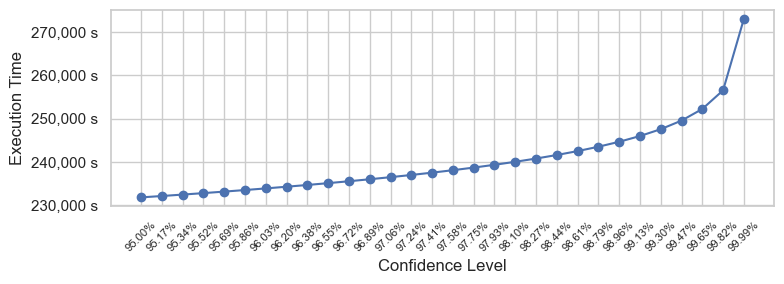

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FuncFormatter
import locale

# Set to German locale to get comma as thousand separator
locale.setlocale(locale.LC_ALL, 'en_US')

# Unpack the data into x and y lists
x, y = zip(*results)

# Create a new figure with the specified figsize
plt.figure(figsize=(8, 3))

# Create a scatter plot
plt.scatter(x, y)

# Alternatively, create a line plot
plt.plot(x, y)

# Custom y-axis tick labels with "s"
def format_y_ticks(value, tick_number):
    # Use locale to format the number with comma as thousand separator
    formatted = locale.format_string("%d", value, grouping=True)
    return f"{formatted} s"

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))

# Add percentage unit and detailed ticks to the x-axis
ax.xaxis.set_major_locator(FixedLocator(x))
ax.set_xticklabels(['{:.2f}%'.format(val) for val in x], rotation=45, fontsize=8)

# Add labels to the axes
plt.xlabel('Confidence Level')
plt.ylabel('Execution Time')

# Remove extra white space
plt.tight_layout()

# Save the plot as an SVG file
plt.savefig("demo_data/images/sensitivity_confidence.svg", format="svg")

# Show the plot
plt.show()


# 5. Graphical User Interface (GUI)
In order to enhance user comprehension of the Smart Stochastic Scheduling approach, we're going to build a GUI for the framework. We'll employ the `ipywidgets` library to craft an interactive user interface, enabling the execution of the `smart_stochastic_scheduling` function in response to a user-defined confidence level.

In [31]:
import ipywidgets as widgets
from IPython.display import display, clear_output, Javascript

# Create a label for the headline
headline = widgets.HTML(value='<h2 style="font-weight: bold;">Smart Stochastic Scheduling (SSS)</h2>', layout=widgets.Layout(margin='0 0 10px 0'))

# Create a label for the description
description = widgets.Label(value='Please select the desired confidence level and click the button to run the optimization.', layout=widgets.Layout(margin='0 0 10px 0'))

# Create a slider for the confidence_level
confidence_slider = widgets.FloatSlider(
    value=95.5,
    min=95,
    max=99.99,
    step=0.01,
    description='Confidence Level (%):',
    readout_format='.2f',
    style={'description_width': 'initial'},
)

# Create a text input field for the confidence_level
confidence_text = widgets.FloatText(
    value=95.5,
    step=0.01,
    description='Confidence Level (%):',
    style={'description_width': 'initial'},
)

# Link the slider and text input field
widgets.link((confidence_slider, 'value'), (confidence_text, 'value'))


# Create a button widget
button = widgets.Button(description='Run optimization',button_style='success')

# Create an animated loading widget using HTML and CSS
loading_widget = widgets.HTML(
    value='<div style="font-size: 14px;">Optimizing: <i class="fa fa-spinner fa-spin"></i></div>',
    layout=widgets.Layout(visibility='hidden')  # Hide the loading widget initially
)

# Create a separator
separator = widgets.HTML(value='<hr>')

# Create an Output Widget with a limited height
output = widgets.Output(layout=widgets.Layout(height='200px', overflow='auto'))

def on_button_clicked(b):
    with output:
        # Disable the button while the function is running
        button.disabled = True
        
        # Display the loading widget
        loading_widget.layout.visibility = 'visible'

        # clear output
        clear_output()
        
        # run function
        result = smart_stochastic_scheduling(future_jobs, confidence_slider.value / 100)  # Divide by 100 to convert back to fraction
        
        # Enable button and hide the loading animation
        button.disabled = False
        loading_widget.layout.visibility = 'hidden'
        
        # print result
        print(f'')
        print(f'_____________________________')
        print(f'')
        print(f'Total runtime: {int(result)} seconds.')

# Adds the event-handler to the button
button.on_click(on_button_clicked)

# Display the widgets
display(headline, description, confidence_slider, confidence_text, button, loading_widget, separator, output)


HTML(value='<h2 style="font-weight: bold;">Smart Stochastic Scheduling (SSS)</h2>', layout=Layout(margin='0 0 …

Label(value='Please select the desired confidence level and click the button to run the optimization.', layout…

FloatSlider(value=95.5, description='Confidence Level (%):', max=99.99, min=95.0, step=0.01, style=SliderStyle…

FloatText(value=95.5, description='Confidence Level (%):', step=0.01, style=DescriptionStyle(description_width…

Button(button_style='success', description='Run optimization', style=ButtonStyle())

HTML(value='<div style="font-size: 14px;">Optimizing: <i class="fa fa-spinner fa-spin"></i></div>', layout=Lay…

HTML(value='<hr>')

Output(layout=Layout(height='200px', overflow='auto'))